In [3]:
import sqlite3
import pandas as pd

# Connect to SQLite (in-memory for demo)
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Create table
cursor.execute('''
CREATE TABLE operations (
    Date TEXT,
    SKU_ID TEXT,
    Category TEXT,
    Country TEXT,
    Quantity INTEGER,
    Unit_Cost REAL,
    Distribution_Cost REAL,
    Labor_Cost REAL,
    Repair_Cost REAL,
    Advertisement_Cost REAL,
    Revenue REAL
)
''')

# Insert sample data
sample_data = [
    ('2024-01-01', 'SKU001', 'Electronics', 'India', 200, 40, 5000, 3000, 1000, 2000, 16000),
    ('2024-01-02', 'SKU002', 'Furniture', 'Germany', 150, 60, 4000, 2500, 800, 1800, 14000),
    ('2024-01-03', 'SKU003', 'Apparel', 'India', 300, 20, 3500, 1500, 600, 1200, 18000),
    ('2024-01-04', 'SKU004', 'Electronics', 'USA', 180, 50, 6000, 3200, 1200, 2200, 19000),
    ('2024-01-05', 'SKU005', 'Furniture', 'France', 100, 70, 4500, 2700, 900, 2000, 15000)
]

cursor.executemany('INSERT INTO operations VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', sample_data)
conn.commit()


In [5]:
query = '''
SELECT *,
    (Quantity * Unit_Cost + Distribution_Cost + Labor_Cost + Repair_Cost + Advertisement_Cost) AS Total_Cost,
    (Revenue - (Quantity * Unit_Cost + Distribution_Cost + Labor_Cost + Repair_Cost + Advertisement_Cost)) AS Profit,
    ROUND((Revenue - (Quantity * Unit_Cost + Distribution_Cost + Labor_Cost + Repair_Cost + Advertisement_Cost)) * 1.0 / Revenue, 2) AS Profit_Margin
FROM operations
'''
df = pd.read_sql_query(query, conn)
print(df)


         Date  SKU_ID     Category  Country  Quantity  Unit_Cost  \
0  2024-01-01  SKU001  Electronics    India       200       40.0   
1  2024-01-02  SKU002    Furniture  Germany       150       60.0   
2  2024-01-03  SKU003      Apparel    India       300       20.0   
3  2024-01-04  SKU004  Electronics      USA       180       50.0   
4  2024-01-05  SKU005    Furniture   France       100       70.0   

   Distribution_Cost  Labor_Cost  Repair_Cost  Advertisement_Cost  Revenue  \
0             5000.0      3000.0       1000.0              2000.0  16000.0   
1             4000.0      2500.0        800.0              1800.0  14000.0   
2             3500.0      1500.0        600.0              1200.0  18000.0   
3             6000.0      3200.0       1200.0              2200.0  19000.0   
4             4500.0      2700.0        900.0              2000.0  15000.0   

   Total_Cost  Profit  Profit_Margin  
0     19000.0 -3000.0          -0.19  
1     18100.0 -4100.0          -0.29  
2    

In [13]:
print("Total Revenue:", df['Revenue'].sum())
print("Total Cost:", df['Total_Cost'].sum())
print("Total Profit:", df['Profit'].sum())
print("Average Profit Margin:", round(df['Profit_Margin'].mean(), 3))


Total Revenue: 82000.0
Total Cost: 88600.0
Total Profit: -6600.0
Average Profit Margin: -0.094


In [15]:
category_summary = df.groupby('Category').agg({
    'Revenue': 'sum',
    'Total_Cost': 'sum',
    'Profit': 'sum',
    'Profit_Margin': 'mean'
}).sort_values(by='Profit', ascending=False)
print(category_summary)


             Revenue  Total_Cost  Profit  Profit_Margin
Category                                               
Apparel      18000.0     12800.0  5200.0          0.290
Electronics  35000.0     40600.0 -5600.0         -0.165
Furniture    29000.0     35200.0 -6200.0         -0.215


In [7]:
least_profitable = df.groupby('Category')['Profit'].mean().sort_values().head(3)
print("Low-performing categories:\n", least_profitable)

Low-performing categories:
 Category
Furniture     -3100.0
Electronics   -2800.0
Apparel        5200.0
Name: Profit, dtype: float64


In [17]:
country_margin = df.groupby('Country')['Profit_Margin'].mean().sort_values()
print(country_margin)


Country
Germany   -0.29
France    -0.14
USA       -0.14
India      0.05
Name: Profit_Margin, dtype: float64


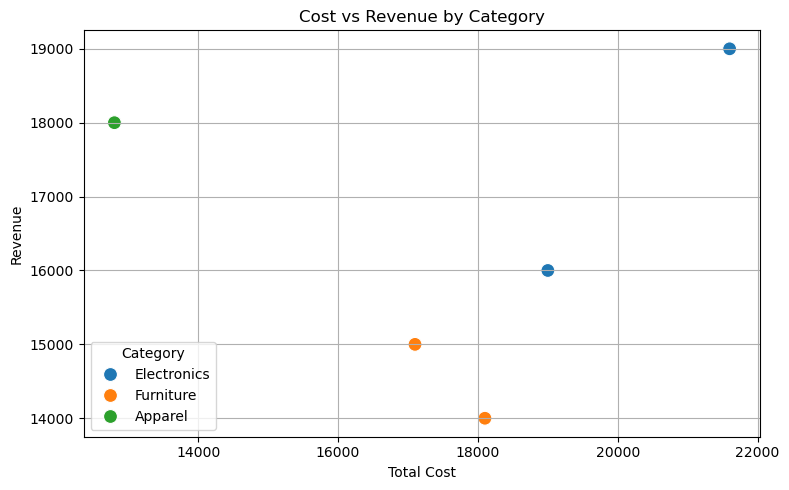

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Total_Cost', y='Revenue', hue='Category', s=100)
plt.title("Cost vs Revenue by Category")
plt.xlabel("Total Cost")
plt.ylabel("Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
margin_by_country = df.groupby('Country')['Profit_Margin'].mean().sort_values(ascending=False)
print("Profit Margin by Country:\n", margin_by_country)

Profit Margin by Country:
 Country
India      0.05
France    -0.14
USA       -0.14
Germany   -0.29
Name: Profit_Margin, dtype: float64


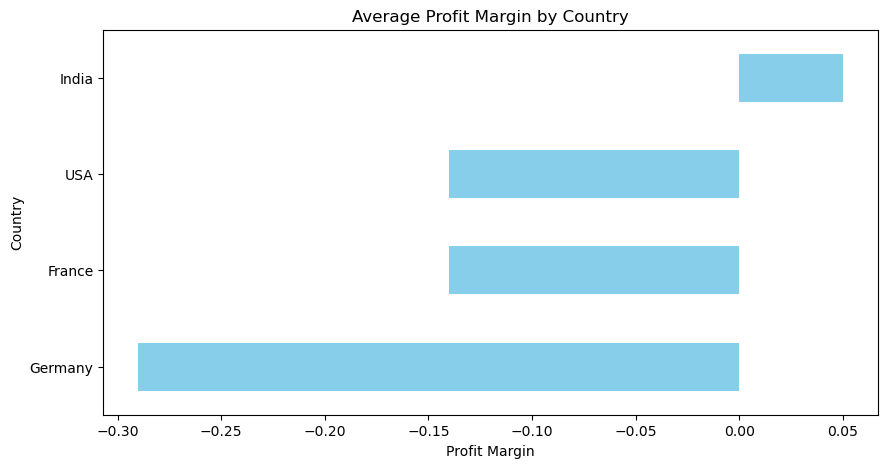

In [19]:
plt.figure(figsize=(10,5))
country_margin.plot(kind='barh', color='skyblue')
plt.title('Average Profit Margin by Country')
plt.xlabel('Profit Margin')
plt.show()


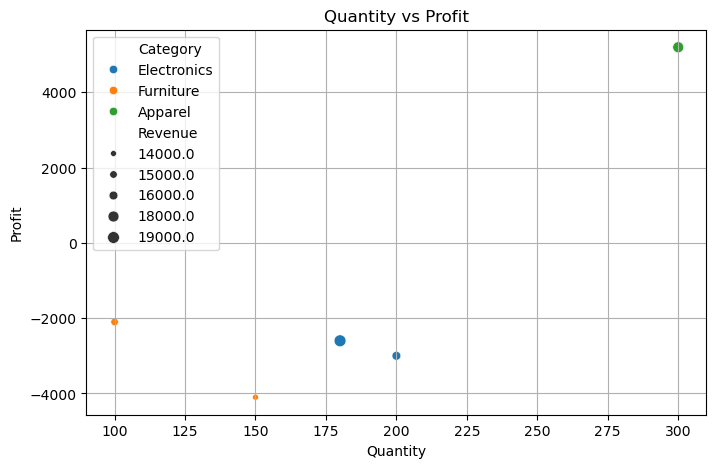

In [21]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Quantity', y='Profit', hue='Category', size='Revenue')
plt.title('Quantity vs Profit')
plt.grid(True)
plt.show()


In [23]:
low_margin_high_revenue = df[(df['Profit_Margin'] < 0.05) & (df['Revenue'] > 10000)]
print("Low Margin High Revenue SKUs:\n", low_margin_high_revenue[['SKU_ID', 'Revenue', 'Profit_Margin']])


Low Margin High Revenue SKUs:
    SKU_ID  Revenue  Profit_Margin
0  SKU001  16000.0          -0.19
1  SKU002  14000.0          -0.29
3  SKU004  19000.0          -0.14
4  SKU005  15000.0          -0.14
